In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

print("=" * 60)
print("CANAL FEATURES PER WARD CALCULATION")
print("=" * 60)

# Define paths
DATA_DIR = Path('../data')
CANAL_DIR = DATA_DIR / 'canals'
WARDS_DIR = DATA_DIR / 'wards'  # UPDATED

print(f"\n📂 Working directory: {Path.cwd()}")
print(f"📂 Canal data: {CANAL_DIR.absolute()}")
print(f"📂 Wards data: {WARDS_DIR.absolute()}")

# Load data
print("\n📂 Loading data...")
canals = gpd.read_file(CANAL_DIR / 'kolkata_all_waterways.geojson')
wards = gpd.read_file(WARDS_DIR / 'kmc_wards_clean.gpkg')  # UPDATED: .gpkg format

print(f"✓ Loaded {len(wards)} wards from GeoPackage")
print(f"✓ Loaded {len(canals)} canals")
print(f"  Ward CRS: {wards.crs}")
print(f"  Canal CRS: {canals.crs}")

# Check ward columns
print(f"\n📋 Ward file columns:")
print(f"   {list(wards.columns)}")

# CRITICAL: Project to UTM for accurate measurements
print(f"\n🌍 Projecting to UTM Zone 45N...")
utm_crs = 'EPSG:32645'

wards_utm = wards.to_crs(utm_crs)
canals_utm = canals.to_crs(utm_crs)

print(f"✓ Projected to {utm_crs}")
print(f"✓ Ready to calculate features for {len(wards)} wards")

CANAL FEATURES PER WARD CALCULATION

📂 Working directory: /Users/romitbasak/Projects/KolkataFloodMapping/notebooks
📂 Canal data: /Users/romitbasak/Projects/KolkataFloodMapping/notebooks/../data/canals
📂 Wards data: /Users/romitbasak/Projects/KolkataFloodMapping/notebooks/../data/wards

📂 Loading data...
✓ Loaded 141 wards from GeoPackage
✓ Loaded 98 canals
  Ward CRS: EPSG:4326
  Canal CRS: EPSG:4326

📋 Ward file columns:
   ['WARD', 'geometry']

🌍 Projecting to UTM Zone 45N...
✓ Projected to EPSG:32645
✓ Ready to calculate features for 141 wards


In [3]:
# Calculate canal features per ward
print(f"\n⚙️  Calculating canal features per ward...")

ward_canal_features = []

for idx, ward in wards_utm.iterrows():
    if idx % 20 == 0:
        print(f"   Processing ward {idx+1}/{len(wards_utm)}...")

    ward_geom = ward.geometry
    ward_area_km2 = ward_geom.area / 1e6  # m² to km²

    # Find canals intersecting this ward
    intersecting_canals = canals_utm[canals_utm.intersects(ward_geom)]

    # Get ward identifiers
    ward_id_raw = ward.get('WARD', ward.get('ward_no', ward.get('WARD_NO', ward.get('id', idx))))
    ward_id = str(ward_id_raw)
    ward_name = ward.get('ward_name', ward.get('WARD_NAME', ward.get('NAME', f'Ward_{ward_id}')))

    # Initialize features
    features = {
        'ward_id': ward_id,
        'ward_name': ward_name,
        'ward_area_km2': ward_area_km2,
        'canal_count': len(intersecting_canals),
        'canal_count_major': 0,
        'canal_count_drain': 0,
        'canal_count_river': 0,
        'canal_length_km': 0,
        'canal_length_major_km': 0,
        'canal_length_drain_km': 0,
        'canal_density': 0,
        'has_canal': False,
        'has_major_canal': False,
        'has_named_canal': False,
        'has_river': False,
        'named_canals': '',
        'distance_to_canal_m': 0,
        'primary_drainage_type': 'unknown'
    }

    if len(intersecting_canals) > 0:
        # Calculate lengths (clipped to ward boundary)
        total_length = 0
        major_length = 0
        drain_length = 0
        named_canals = []

        canal_counts = {'canal': 0, 'drain': 0, 'river': 0}

        for _, canal in intersecting_canals.iterrows():
            try:
                clipped = canal.geometry.intersection(ward_geom)
                if not clipped.is_empty:
                    length_m = clipped.length  # Meters in UTM
                    length_km = length_m / 1000
                    total_length += length_km

                    # Categorize
                    wtype = canal['waterway']
                    if wtype in canal_counts:
                        canal_counts[wtype] += 1

                    if wtype == 'canal':
                        major_length += length_km
                    elif wtype == 'drain':
                        drain_length += length_km

                    # Named canals
                    if pd.notna(canal.get('name')):
                        named_canals.append(canal['name'])
            except:
                continue

        # Update features
        features['canal_count_major'] = canal_counts['canal']
        features['canal_count_drain'] = canal_counts['drain']
        features['canal_count_river'] = canal_counts['river']
        features['canal_length_km'] = total_length
        features['canal_length_major_km'] = major_length
        features['canal_length_drain_km'] = drain_length
        features['canal_density'] = total_length / ward_area_km2 if ward_area_km2 > 0 else 0
        features['has_canal'] = True
        features['has_major_canal'] = major_length > 0
        features['has_river'] = canal_counts['river'] > 0
        features['has_named_canal'] = len(named_canals) > 0
        features['named_canals'] = ', '.join(set(named_canals))

        # Infer drainage type
        if features['has_river']:
            features['primary_drainage_type'] = 'river'
        elif major_length > drain_length:
            features['primary_drainage_type'] = 'canal'
        elif drain_length > 0:
            features['primary_drainage_type'] = 'drain'
        else:
            features['primary_drainage_type'] = 'mixed'
    else:
        # No canals - calculate distance to nearest
        ward_centroid = ward_geom.centroid
        if len(canals_utm) > 0:
            distances = canals_utm.geometry.distance(ward_centroid)
            features['distance_to_canal_m'] = distances.min()
            features['primary_drainage_type'] = 'pipe'

    ward_canal_features.append(features)

# Create DataFrame
canal_features_df = pd.DataFrame(ward_canal_features)

print(f"\n✓ Calculated features for all {len(canal_features_df)} wards")


⚙️  Calculating canal features per ward...
   Processing ward 1/141...
   Processing ward 21/141...
   Processing ward 41/141...
   Processing ward 61/141...
   Processing ward 81/141...
   Processing ward 101/141...
   Processing ward 121/141...
   Processing ward 141/141...

✓ Calculated features for all 141 wards


In [4]:
# Summary statistics
print(f"\n📊 CANAL COVERAGE SUMMARY:")
print(f"   Wards with canals: {canal_features_df['has_canal'].sum()} ({canal_features_df['has_canal'].sum()/len(canal_features_df)*100:.1f}%)")
print(f"   Wards with major canals: {canal_features_df['has_major_canal'].sum()}")
print(f"   Wards with named canals: {canal_features_df['has_named_canal'].sum()}")
print(f"   Wards with river segments: {canal_features_df['has_river'].sum()}")

print(f"\n📏 CANAL LENGTH STATISTICS:")
print(f"   Total canal length: {canal_features_df['canal_length_km'].sum():.1f} km")
print(f"   Mean per ward: {canal_features_df['canal_length_km'].mean():.2f} km")
print(f"   Median per ward: {canal_features_df['canal_length_km'].median():.2f} km")
print(f"   Max in single ward: {canal_features_df['canal_length_km'].max():.2f} km")
print(f"   Wards with >1km canals: {(canal_features_df['canal_length_km'] > 1).sum()}")

print(f"\n🗺️  CANAL DENSITY STATISTICS:")
print(f"   Mean density: {canal_features_df['canal_density'].mean():.2f} km/km²")
print(f"   Median density: {canal_features_df['canal_density'].median():.2f} km/km²")
print(f"   Max density: {canal_features_df['canal_density'].max():.2f} km/km²")

print(f"\n🏗️  PRIMARY DRAINAGE TYPE:")
drainage_types = canal_features_df['primary_drainage_type'].value_counts()
for dtype, count in drainage_types.items():
    print(f"   {dtype}: {count} wards ({count/len(canal_features_df)*100:.1f}%)")

# Top wards by canal length
print(f"\n🏆 TOP 10 WARDS BY CANAL LENGTH:")
top_wards = canal_features_df.nlargest(10, 'canal_length_km')[
    ['ward_name', 'canal_length_km', 'canal_density', 'named_canals']
]
for idx, row in top_wards.iterrows():
    canals_str = str(row['named_canals'])[:40] + '...' if len(str(row['named_canals'])) > 40 else row['named_canals']
    print(f"   {row['ward_name']}: {row['canal_length_km']:.2f} km (density: {row['canal_density']:.2f}) - {canals_str}")

# Show sample data
print(f"\n📋 SAMPLE DATA (first 5 wards):")
print(canal_features_df[['ward_name', 'canal_length_km', 'canal_density', 'primary_drainage_type']].head())


📊 CANAL COVERAGE SUMMARY:
   Wards with canals: 44 (31.2%)
   Wards with major canals: 22
   Wards with named canals: 30
   Wards with river segments: 17

📏 CANAL LENGTH STATISTICS:
   Total canal length: 59.4 km
   Mean per ward: 0.42 km
   Median per ward: 0.00 km
   Max in single ward: 15.61 km
   Wards with >1km canals: 18

🗺️  CANAL DENSITY STATISTICS:
   Mean density: 0.24 km/km²
   Median density: 0.00 km/km²
   Max density: 2.09 km/km²

🏗️  PRIMARY DRAINAGE TYPE:
   pipe: 97 wards (68.8%)
   canal: 21 wards (14.9%)
   river: 17 wards (12.1%)
   drain: 5 wards (3.5%)
   mixed: 1 wards (0.7%)

🏆 TOP 10 WARDS BY CANAL LENGTH:
   Ward_108
: 15.61 km (density: 1.31) - Panchanangram Canal, Lead Canal, south p...
   Ward_107
: 4.59 km (density: 1.70) - Lead Canal, south purbachal canal
   Ward_74
: 3.98 km (density: 1.19) - Rhinocerous Enclosure, Pelican, Stork an...
   Ward_106
: 2.62 km (density: 1.37) - Panchanangram Canal, south purbachal can...
   Ward_103
: 2.00 km (density: 2.

In [5]:
# Save to CSV
print(f"\n💾 Saving results...")
canal_features_df.to_csv(CANAL_DIR / 'ward_canal_features.csv', index=False)
print(f"✓ Saved: {CANAL_DIR / 'ward_canal_features.csv'}")

# Merge with ward shapefile
ward_id_col = 'WARD'  # Adjust if your column is named differently
wards['ward_id_str'] = wards[ward_id_col].astype(str)

wards_with_canals = wards.merge(
    canal_features_df[['ward_id', 'canal_length_km', 'canal_density',
                       'primary_drainage_type', 'has_major_canal']],
    left_on='ward_id_str',
    right_on='ward_id',
    how='left'
)

# Fill NaN for wards without canals
wards_with_canals['canal_length_km'] = wards_with_canals['canal_length_km'].fillna(0)
wards_with_canals['canal_density'] = wards_with_canals['canal_density'].fillna(0)
wards_with_canals['primary_drainage_type'] = wards_with_canals['primary_drainage_type'].fillna('pipe')
wards_with_canals['has_major_canal'] = wards_with_canals['has_major_canal'].fillna(False)

wards_with_canals.to_file(CANAL_DIR / 'kmc_wards_with_canal_features.geojson', driver='GeoJSON')
print(f"✓ Saved: {CANAL_DIR / 'kmc_wards_with_canal_features.geojson'}")

print("\n✅ CANAL FEATURE EXTRACTION COMPLETE!")


💾 Saving results...
✓ Saved: ../data/canals/ward_canal_features.csv
✓ Saved: ../data/canals/kmc_wards_with_canal_features.geojson

✅ CANAL FEATURE EXTRACTION COMPLETE!



🗺️  Creating visualizations...

✓ Saved: ../data/canals/ward_canal_analysis.png


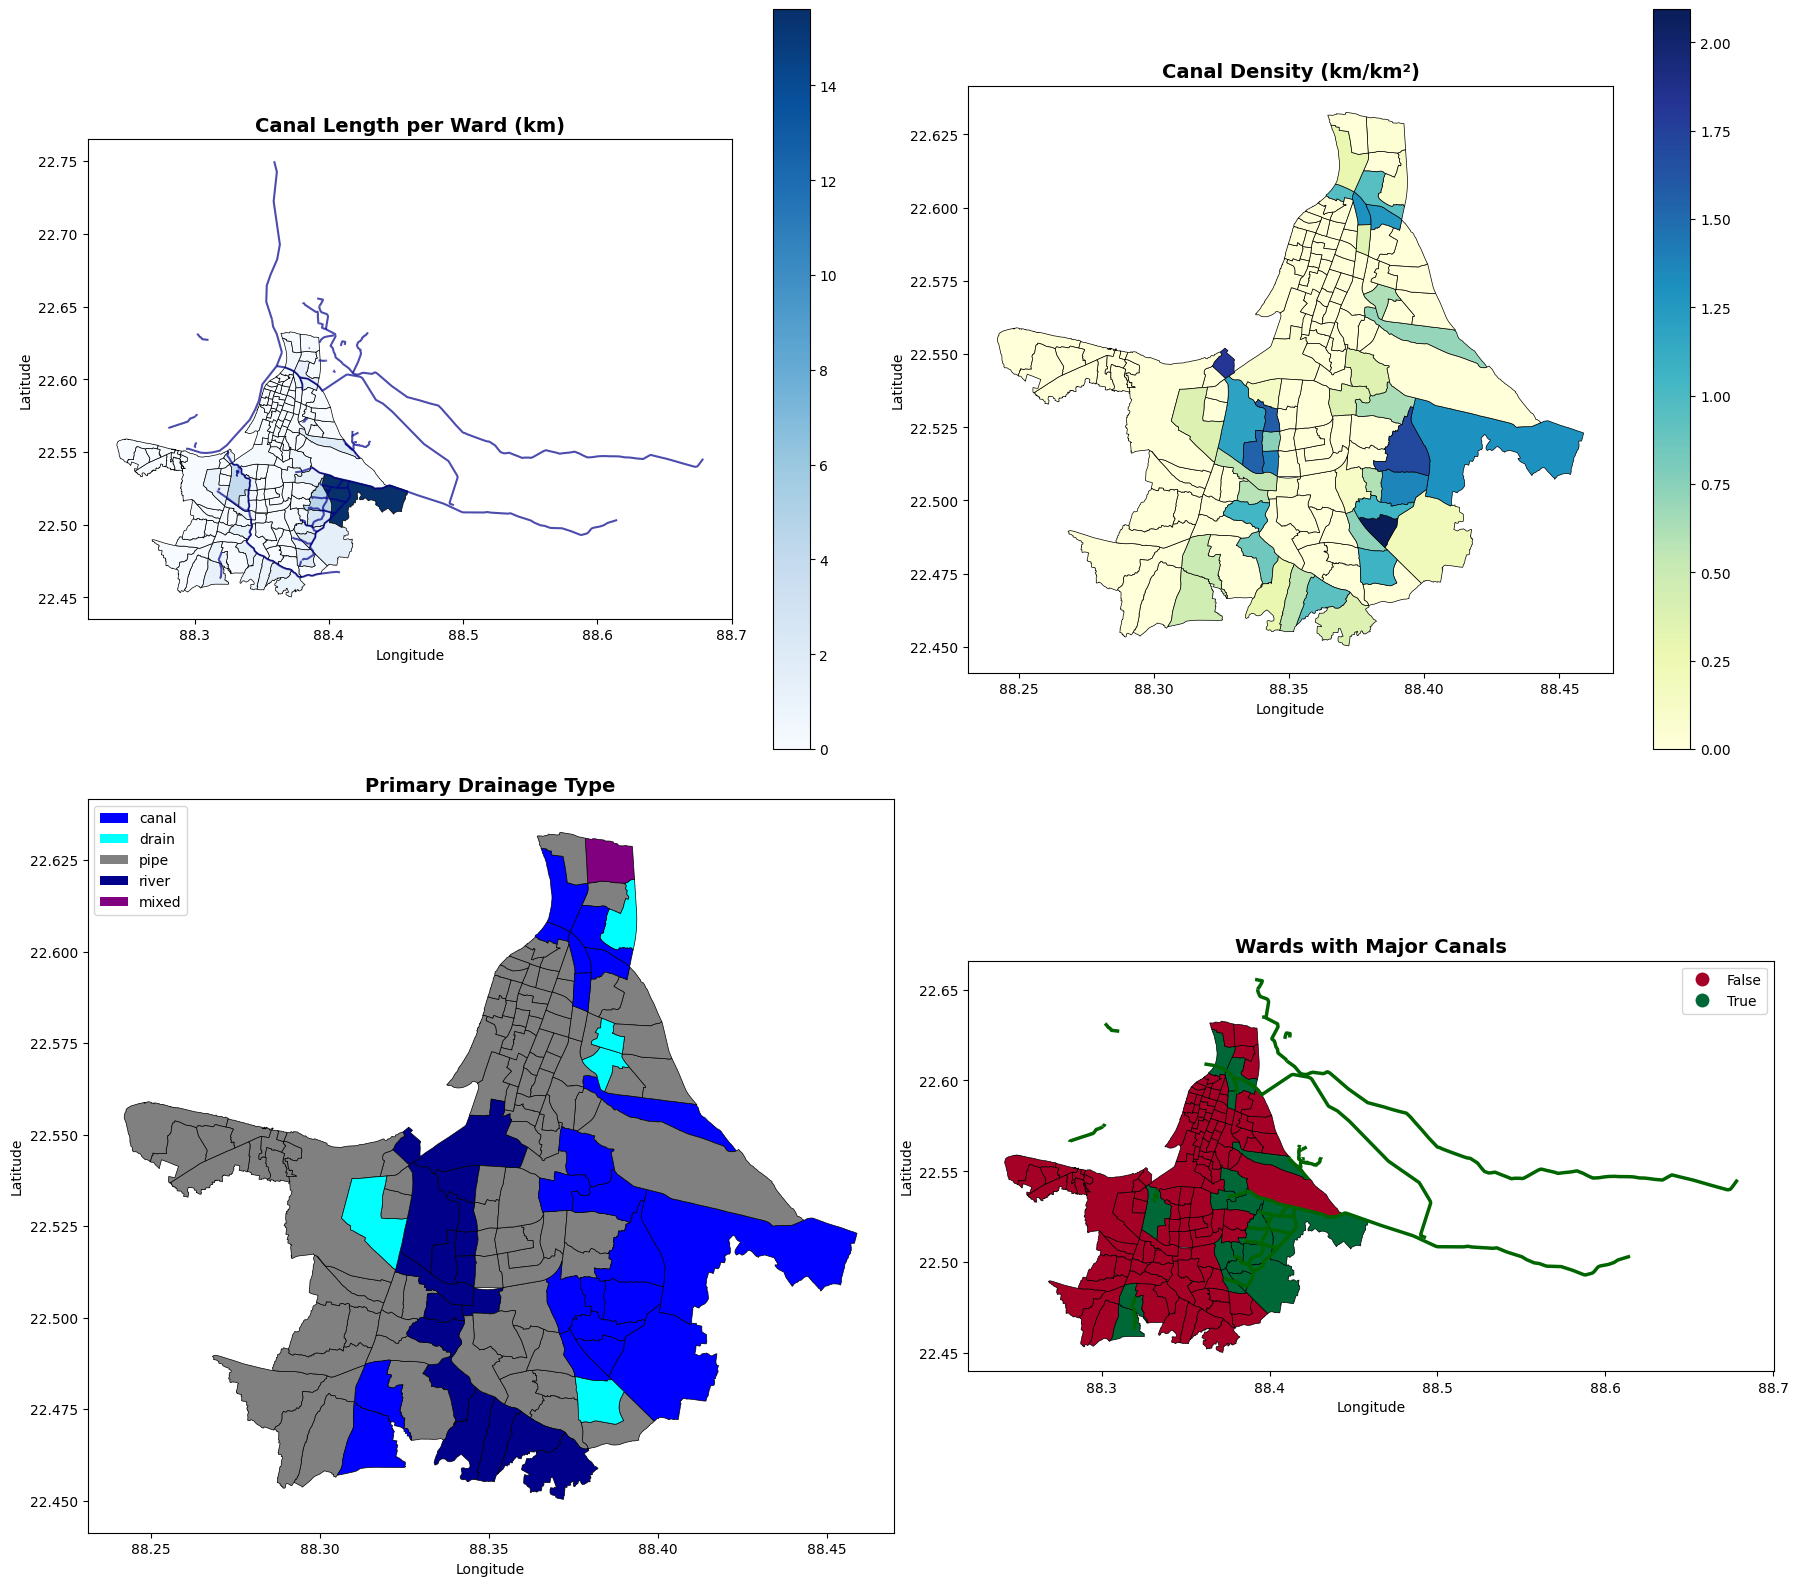


✅ CANAL FEATURE EXTRACTION COMPLETE!


In [6]:
# Create visualizations
print(f"\n🗺️  Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# 1. Canal length per ward
ax1 = axes[0, 0]
wards_with_canals.plot(column='canal_length_km', cmap='Blues', legend=True,
                       ax=ax1, edgecolor='black', linewidth=0.5,
                       missing_kwds={'color': 'lightgray'})
canals.to_crs(wards.crs).plot(ax=ax1, color='darkblue', linewidth=1.5, alpha=0.7)
ax1.set_title('Canal Length per Ward (km)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# 2. Canal density
ax2 = axes[0, 1]
wards_with_canals.plot(column='canal_density', cmap='YlGnBu', legend=True,
                       ax=ax2, edgecolor='black', linewidth=0.5,
                       missing_kwds={'color': 'lightgray'})
ax2.set_title('Canal Density (km/km²)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# 3. Primary drainage type
ax3 = axes[1, 0]
drainage_colors = {
    'canal': 'blue',
    'drain': 'cyan',
    'pipe': 'gray',
    'river': 'darkblue',
    'mixed': 'purple',
    'unknown': 'lightgray'
}
wards_with_canals['color'] = wards_with_canals['primary_drainage_type'].map(drainage_colors).fillna('lightgray')
wards_with_canals.plot(color=wards_with_canals['color'], ax=ax3,
                       edgecolor='black', linewidth=0.5)
ax3.set_title('Primary Drainage Type', fontsize=14, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=dtype)
                  for dtype, color in drainage_colors.items()
                  if dtype in wards_with_canals['primary_drainage_type'].values]
ax3.legend(handles=legend_elements, loc='upper left')

# 4. Has major canal (binary)
ax4 = axes[1, 1]
wards_with_canals.plot(column='has_major_canal', cmap='RdYlGn', legend=True,
                       ax=ax4, edgecolor='black', linewidth=0.5,
                       missing_kwds={'color': 'lightgray'})
canals_major = canals[canals['waterway'] == 'canal'].to_crs(wards.crs)
canals_major.plot(ax=ax4, color='darkgreen', linewidth=2.5)
ax4.set_title('Wards with Major Canals', fontsize=14, fontweight='bold')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

plt.tight_layout()
plt.savefig(CANAL_DIR / 'ward_canal_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {CANAL_DIR / 'ward_canal_analysis.png'}")

# Display in PyCharm (plots appear in output!)
plt.show()

print("\n" + "=" * 60)
print("✅ CANAL FEATURE EXTRACTION COMPLETE!")
print("=" * 60)